In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
batch_size = 48
img_height = 224
img_width = 224

In [ ]:
data_dir='/content/drive/MyDrive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12546 files belonging to 4 classes.
Using 11292 files for training.
Found 12546 files belonging to 4 classes.
Using 2509 files for validation.


In [ ]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


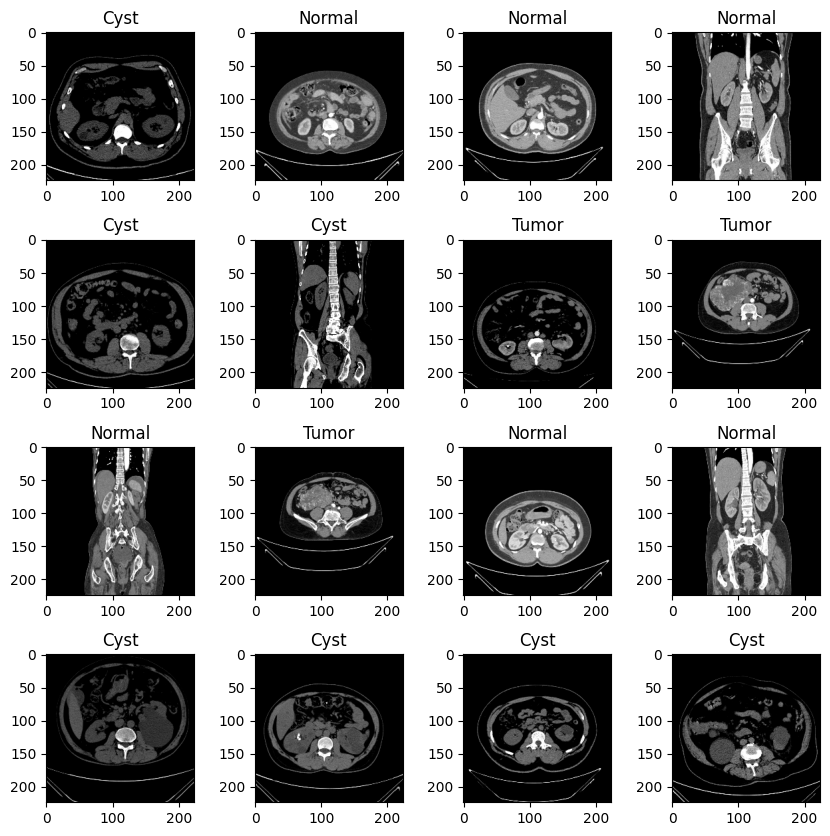

In [ ]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [ ]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3), pooling='max',classes=4, weights='imagenet')


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

In [ ]:
VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                      

In [ ]:
epochs=10
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10
353/353 [==============================] - 1619s 5s/step - loss: 0.4382 - accuracy: 0.8407 - val_loss: 0.3125 - val_accuracy: 0.8741
Epoch 2/10
353/353 [==============================] - 57s 161ms/step - loss: 0.1699 - accuracy: 0.9390 - val_loss: 0.3394 - val_accuracy: 0.8681
Epoch 3/10
353/353 [==============================] - 55s 157ms/step - loss: 0.1241 - accuracy: 0.9558 - val_loss: 0.5430 - val_accuracy: 0.8011
Epoch 4/10
353/353 [==============================] - 56s 158ms/step - loss: 0.0987 - accuracy: 0.9664 - val_loss: 0.1334 - val_accuracy: 0.9538
Epoch 5/10
353/353 [==============================] - 56s 158ms/step - loss: 0.0872 - accuracy: 0.9680 - val_loss: 0.0960 - val_accuracy: 0.9645
Epoch 6/10
353/353 [==============================] - 55s 155ms/step - loss: 0.0766 - accuracy: 0.9737 - val_loss: 0.0639 - val_accuracy: 0.9789
Epoch 7/10
353/353 [==============================] - 56s 158ms/step - loss: 0.0690 - accuracy: 0.9768 - val_loss: 0.0612 - val_acc

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('VGG_training.csv', index=False)

In [ ]:
VGG_model.save('VGG_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


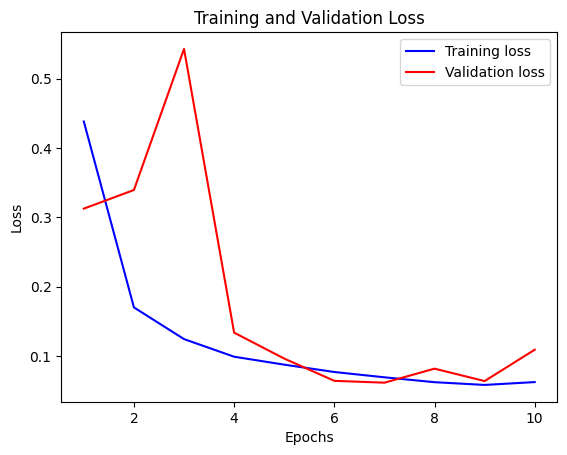

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

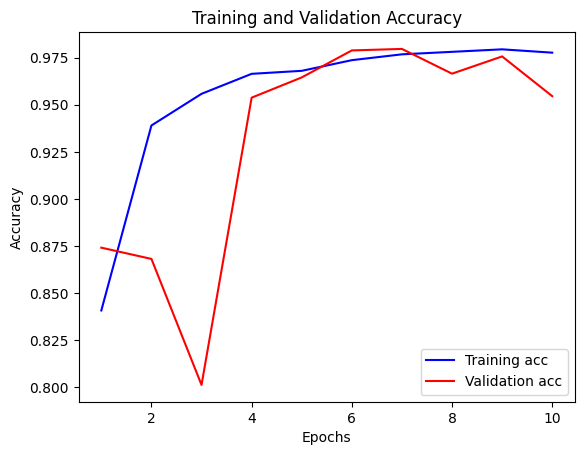

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
predictions = VGG_model.predict(val)

true_labels = np.concatenate([y for x, y in val], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

79/79 [==============================] - 10s 125ms/step


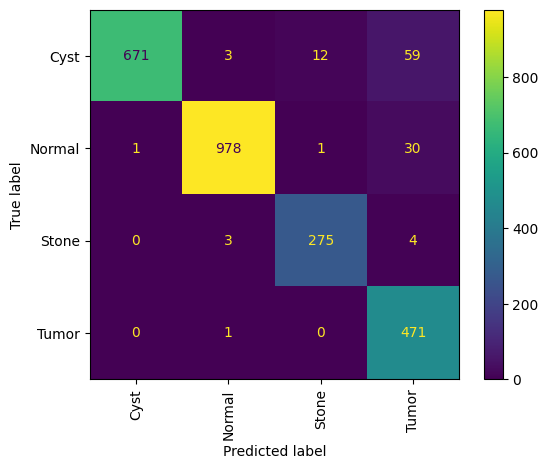

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()

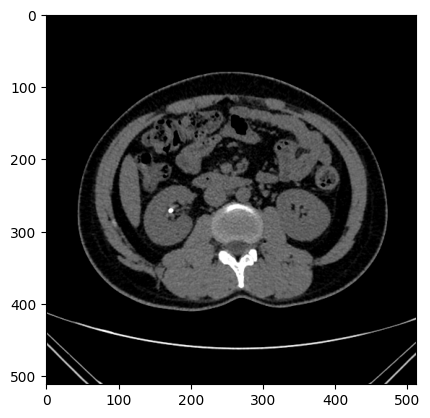

1/1 [==============================] - 2s 2s/step


'Stone'

In [ ]:
img = cv2.imread('/content/drive/MyDrive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1000).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [ ]:
input_shape = (224, 224, 3)
weights = 'imagenet'
num_classes = 1000

In [ ]:
resnet_model = ResNet50(input_shape=input_shape, weights=weights, include_top=False)

for layer in resnet_model.layers:
    layer.trainable = True

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

resnet_net = Model(inputs=resnet_model.input, outputs=output)

94765736/94765736 [==============================] - 13s 0us/step


In [ ]:
resnet_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=10
history = resnet_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10
353/353 [==============================] - 172s 367ms/step - loss: 0.3866 - accuracy: 0.9114 - val_loss: 2.0674 - val_accuracy: 0.4026
Epoch 2/10
353/353 [==============================] - 121s 342ms/step - loss: 0.1119 - accuracy: 0.9835 - val_loss: 3.7349 - val_accuracy: 0.2906
Epoch 3/10
353/353 [==============================] - 121s 343ms/step - loss: 0.0811 - accuracy: 0.9881 - val_loss: 0.9962 - val_accuracy: 0.7561
Epoch 4/10
353/353 [==============================] - 121s 342ms/step - loss: 0.0498 - accuracy: 0.9942 - val_loss: 0.0294 - val_accuracy: 0.9996
Epoch 5/10
353/353 [==============================] - 121s 342ms/step - loss: 0.0560 - accuracy: 0.9906 - val_loss: 1.0994 - val_accuracy: 0.7724
Epoch 6/10
353/353 [==============================] - 121s 342ms/step - loss: 0.0384 - accuracy: 0.9942 - val_loss: 0.0925 - val_accuracy: 0.9741
Epoch 7/10
353/353 [==============================] - 121s 342ms/step - loss: 0.0307 - accuracy: 0.9957 - val_loss: 14.8798 

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('ResNet_training.csv', index=False)
resnet_net.save('ResNet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming you have a model 'model' and a test dataset 'test_dataset'

# Make predictions using your model
predictions = resnet_net.predict(val)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in val], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

# Save the confusion matrix in pkl format
with open('ResNet_confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)

79/79 [==============================] - 8s 92ms/step


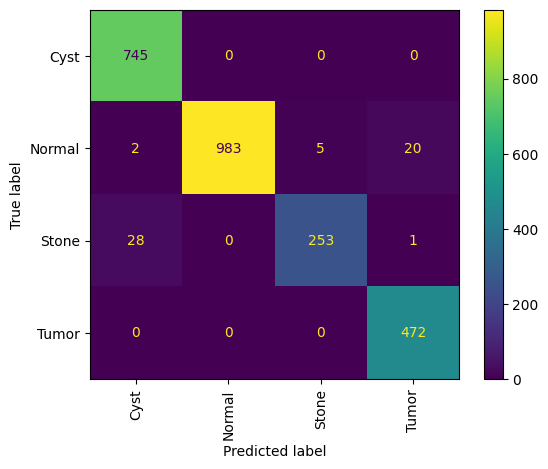

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the saved confusion matrix
with open('ResNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Define class names (assuming you have them)
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']   # Replace with your actual class names

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Show the confusion matrix plot
plt.show()

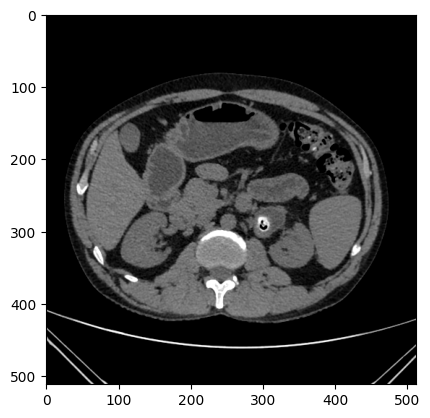

1/1 [==============================] - 2s 2s/step


'Stone'

In [ ]:
img = cv2.imread('/content/drive/MyDrive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1001).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = resnet_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

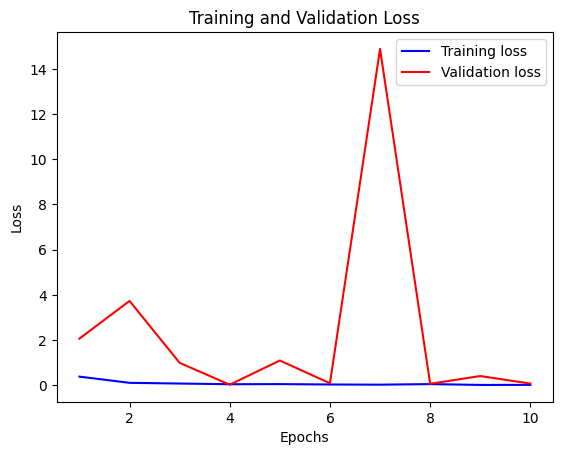

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

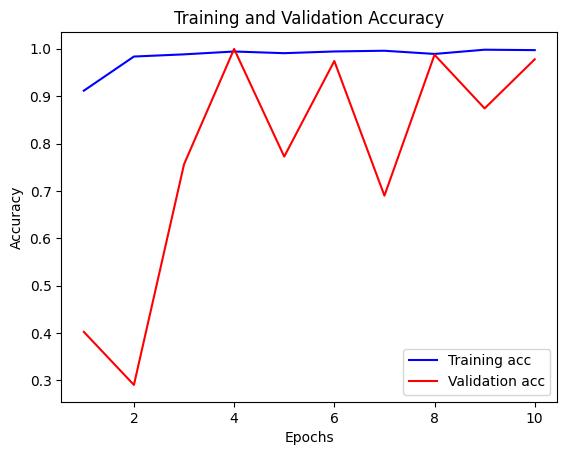

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()